In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
# Libreria para manejo de expresiones regulares
import re
# Libreria para calcula matricial y vectorial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Librerias para Modelado
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot # Change import to use tensorflow.keras
from tensorflow.keras.utils import pad_sequences, plot_model
from tensorflow.keras.models import Sequential # Change import to use tensorflow.keras
from tensorflow.keras.layers import Activation, Dropout, Dense # Change import to use tensorflow.keras
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN # Change import to use tensorflow.keras
from tensorflow.keras.models import Model, load_model # Change import to use tensorflow.keras
from tensorflow.keras.layers import Embedding # Change import to use tensorflow.keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer # Change import to use tensorflow.keras
from tensorflow.keras.layers import Input # C
from keras.utils import to_categorical

In [ ]:
# Librerias necesarias para la descarga de la data
import os
import gdown

In [ ]:
# Descarga de la data

if os.access('data_volunteers.json', os.F_OK) is False:

    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)

else:

    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /kaggle/working/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 170MB/s]


In [ ]:
# dataset_file
import json

text_file = "data_volunteers.json"

with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [ ]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [ ]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt = txt.replace("\'d", " had")
    txt = txt.replace("\'s", " is")
    txt = txt.replace("\'m", " am")
    txt = txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene
        output_sentence = output + '<sos> '
        # output sentence input (decoder_input) tiene
        output_sentence_input = '<eos> ' + output
        #output_sentence_input = '<sos> ' + output_sentence
        #output_sentence_output = output_sentence + ' <eos>'

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 5985


In [ ]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you <sos> ', '<eos> not bad and you ')

In [ ]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000
################################
# Tokenizamos (mapeo de palabras a índices)
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

# Calculamos la secuencia de entrada mas larga
max_input_len = max(len(sen) for sen in input_integer_seq)

print("Máxima secuencia de entrada más larga:", max_input_len)
#print("Secuencias tokenizadas de entrada:", input_integer_seq[:5])


Palabras en el vocabulario: 1783
Máxima secuencia de entrada más larga: 9


In [ ]:
# Tokenizer para los outputs
#tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
#tokenizer_outputs.fit_on_texts(["<sos>", "<eos>"] + output_sentences_inputs)
#output_sequences = tokenizer_outputs.texts_to_sequences(output_sentences)
#output_sequences_inputs = tokenizer_outputs.texts_to_sequences(output_sentences_inputs)


# Guardamos el vocabulario para los outputs
#word2idx_outputs = tokenizer_outputs.word_index
#print(f"Palabras en el vocabulario: {len(word2idx_outputs)}")


#################################################################################################


# sacamos los "<>" para que no afectar nuestros tokens
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<unk>', filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
tokenizer_outputs.fit_on_texts(output_sentences + ['<sos>', '<eos>'])
output_sequences = tokenizer_outputs.texts_to_sequences(output_sentences)
output_sequences_inputs = tokenizer_outputs.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = tokenizer_outputs.word_index
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
max_out_len = max(len(sen) for sen in output_sequences_inputs)
# Define la cantidad de palabras en el vocabulario de salida
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_sequences_inputs)
print("Sentencia de salida más larga:", max_out_len)


Sentencia de salida más larga: 10


In [ ]:
# Longitudes máximas de las secuencias de entrada y salida
max_input_len = max(len(seq) for seq in input_integer_seq)
max_out_len = max(len(seq) for seq in output_sequences_inputs)

# Imprimimos las longitudes
print(f"max_input_len: {max_input_len}")
print(f"max_out_len: {max_out_len}")

max_input_len: 9
max_out_len: 10


In [ ]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_sequences_inputs, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 5985
encoder_input_sequences shape: (5985, 9)
decoder_input_sequences shape: (5985, 10)


In [ ]:
decoder_output_sequences = pad_sequences(output_sequences, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(5985, 10, 2243)

In [ ]:
import logging
from pathlib import Path
import pickle
import numpy as np

class WordsEmbeddings(object):
    """
    WordsEmbeddings class for handling word embeddings.
    """
    logger = logging.getLogger(__name__)

    def __init__(self, embedding_dim, word_to_vec_path, pkl_path, word_max_size=60):
        self.word_to_vec_model_txt_path = word_to_vec_path
        self.pkl_path = pkl_path
        self.n_features = embedding_dim
        self.word_max_size = word_max_size
        self.default_embedding = np.zeros((self.n_features,), dtype=np.float32)  # Default for unknown words

        # Load the embeddings
        words_embedding_pkl = Path(self.pkl_path)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.word_to_vec_model_txt_path)
            assert words_embedding_txt.is_file(), 'Words embedding file not available.'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()

        self.embeddings = embeddings
        # Build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dictionary mapping words to their indices
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        """Get embeddings for a word or a list of words."""
        if isinstance(words, str):
            words = [words]
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        """Convert a list of words to their corresponding indices."""
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        """Convert a list of indices back to their corresponding words."""
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        """Load word embeddings from a pickle file."""
        self.logger.debug('Loading word embeddings from pickle: %s', self.pkl_path)

        try:
            with open(self.pkl_path, 'rb') as f_in:
                embeddings = pickle.load(f_in)
            self.logger.debug('Word embeddings loaded successfully.')
            return embeddings
        except Exception as e:
            raise RuntimeError(f"Failed to load embeddings from {self.pkl_path}: {str(e)}") from e

    def convert_model_to_pickle(self):
        """Convert the word embeddings from the text format to a pickle file."""
        self.logger.debug('Converting and loading embeddings from text file: %s', self.word_to_vec_model_txt_path)
        structure = [('word', np.dtype('U' + str(self.word_max_size))), ('embedding', np.float32, (self.n_features,))]
        structure = np.dtype(structure)

        # Load embeddings from the text file
        with open(self.word_to_vec_model_txt_path, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:])
                for line in words_embeddings_txt
                if len(line.split()[1:]) == self.n_features
            )
            embeddings = np.fromiter(embeddings_gen, structure, count=-1)

        # Add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.n_features,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])

        try:
            with open(self.pkl_path, 'wb') as f_out:
                pickle.dump(embeddings, f_out, protocol=pickle.HIGHEST_PROTOCOL)
            self.logger.debug('Word embeddings loaded and converted to pickle successfully.')
        except Exception as e:
            raise RuntimeError(f"Failed to save embeddings to {self.pkl_path}: {str(e)}") from e

        return embeddings




In [ ]:
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = '/kaggle/input/crawl300d2m/crawl-300d-2M.vec'
    PKL_PATH = '/kaggle/working/fasttext.pkl.pklllq2jvwy.part'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [ ]:
import os
import gdown
if os.access('fasttext.pkl.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = '/kaggle/working/fasttext.pkl.pklllq2jvwy.part'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [ ]:
dim=300
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = FasttextEmbeddings(embedding_dim=dim, word_to_vec_path='/kaggle/input/crawl300d2m/crawl-300d-2M.vec', pkl_path='/kaggle/working/fasttext.pkl.pklllq2jvwy.part')

In [ ]:
# Crear la Embedding matrix de las secuencias
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 95


In [ ]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(1783, 300)

In [ ]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 9, 300)    │    534,900 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 10, 128)   │    287,104 │ input_layer_21[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 128),     │    219,648 │ embedding_10[0][… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ [(None, 10, 128), │    131,584 │ embedding_11[0][… │
│                     │ (None, 128),      │            │ lstm_10[0][1],    │
│                     │ (None, 128)]      │            │ lstm_10[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10, 2243)  │    289,347 │ lstm_11[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,462,583 (5.58 MB)

 Trainable params: 927,683 (3.54 MB)

 Non-trainable params: 534,900 (2.04 MB)

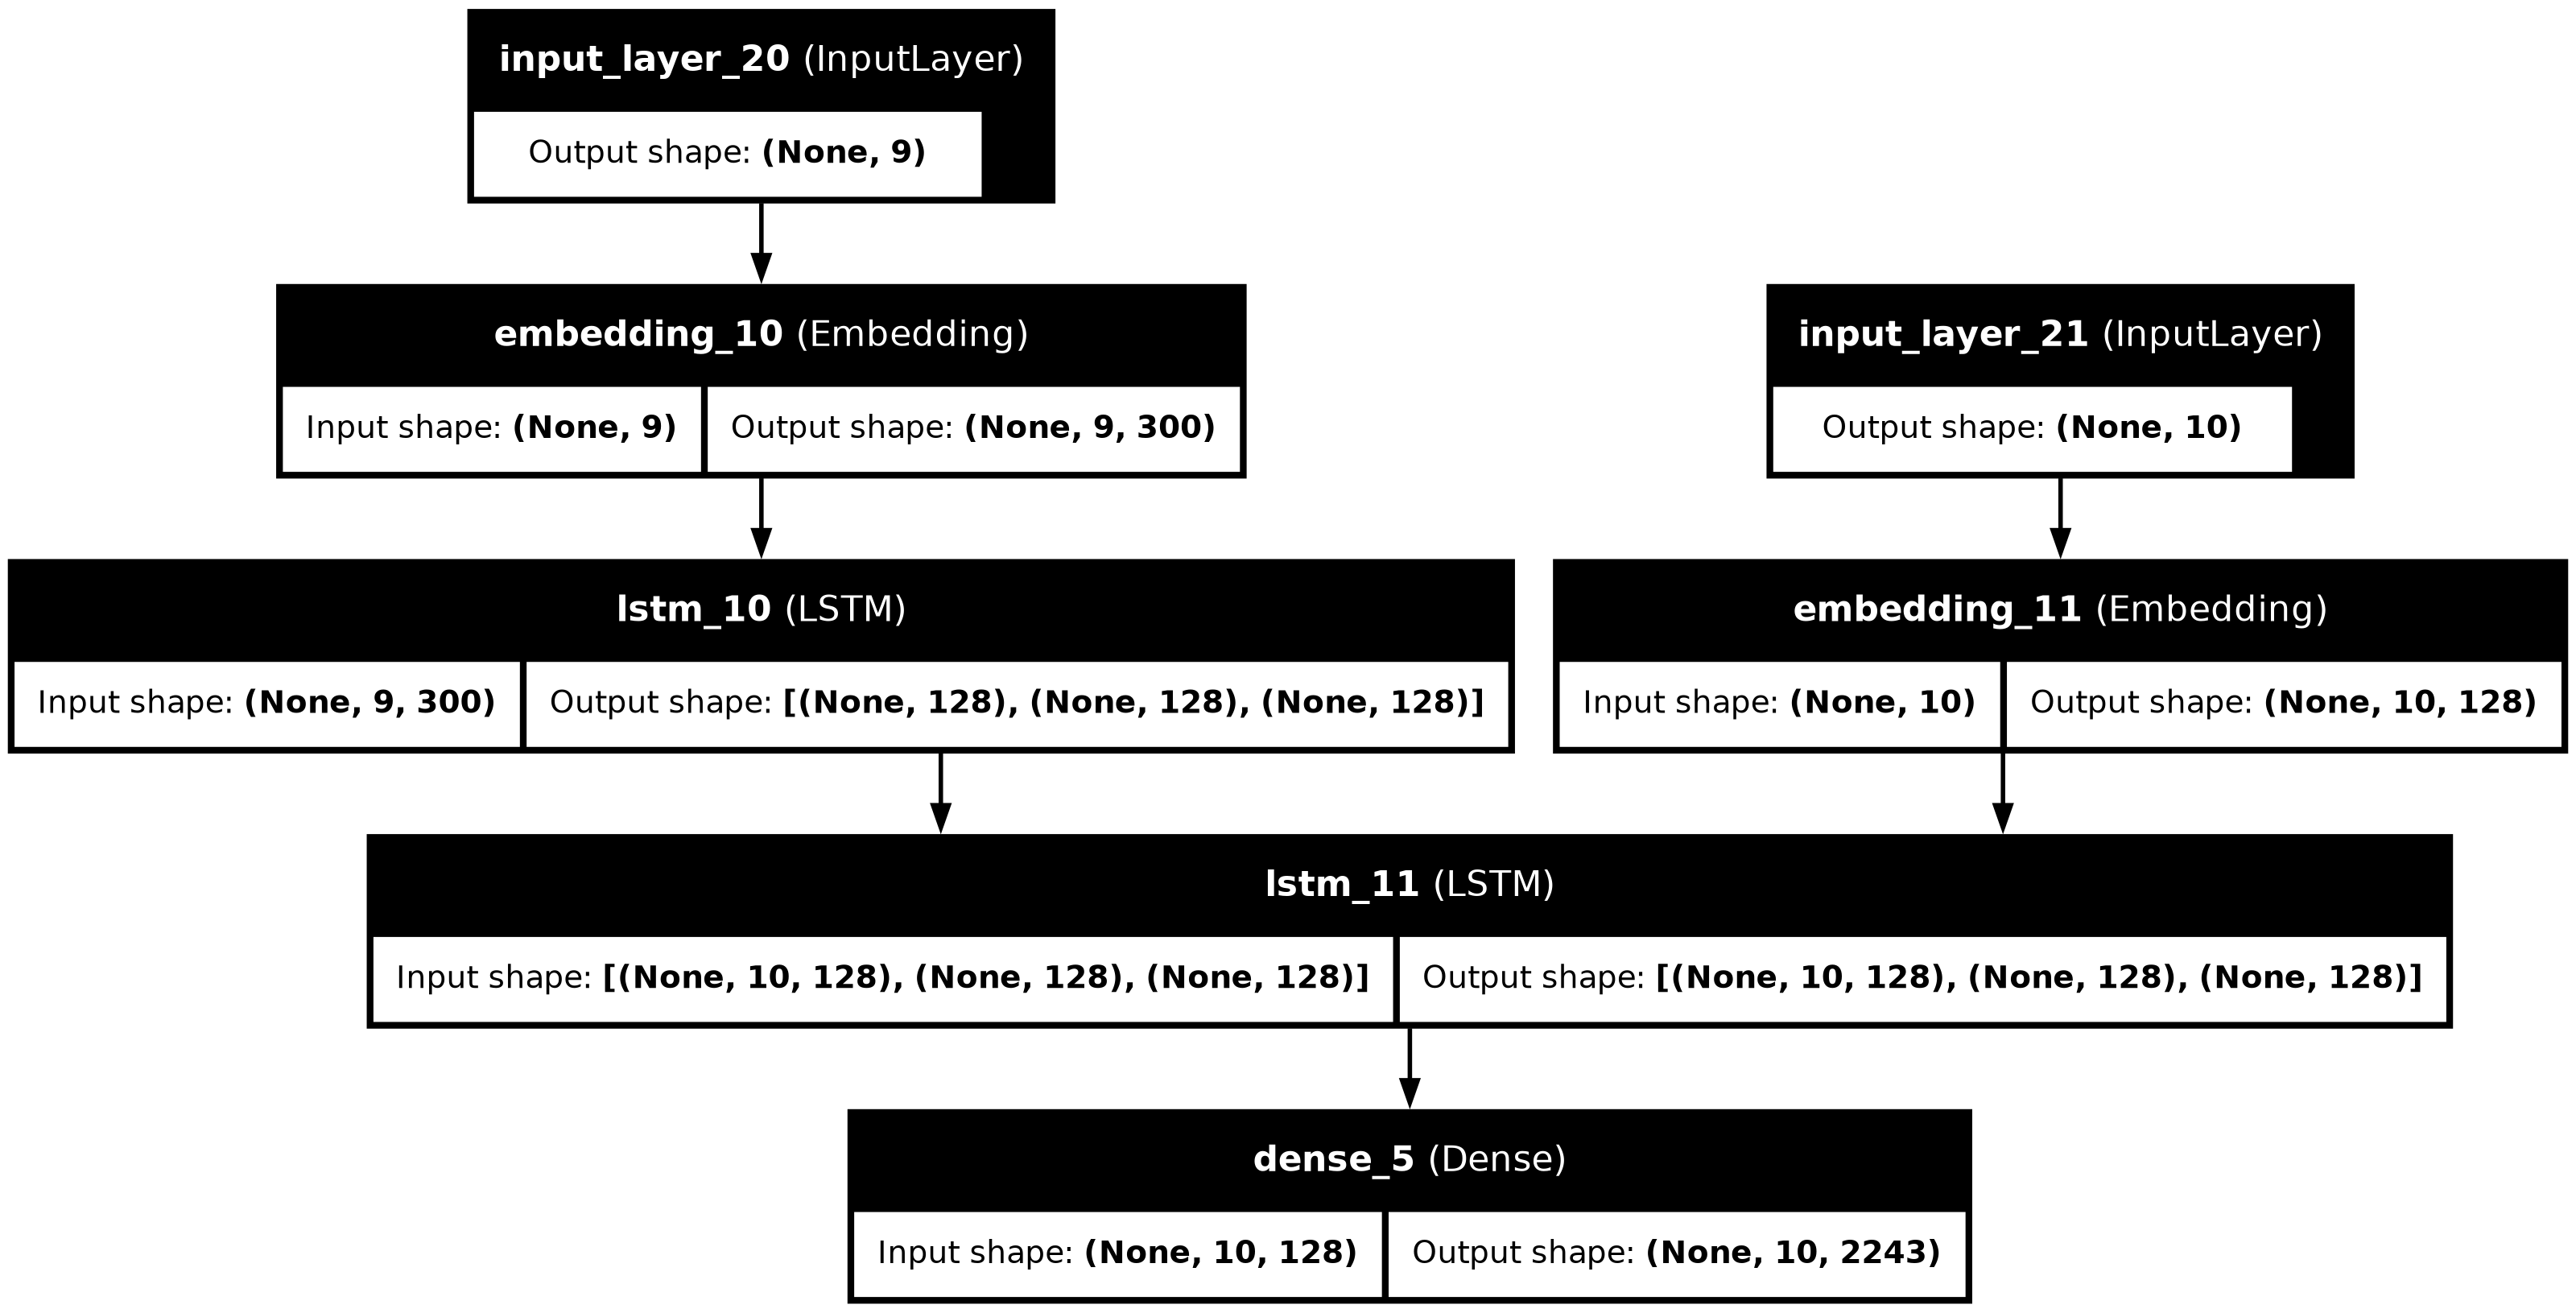

In [ ]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

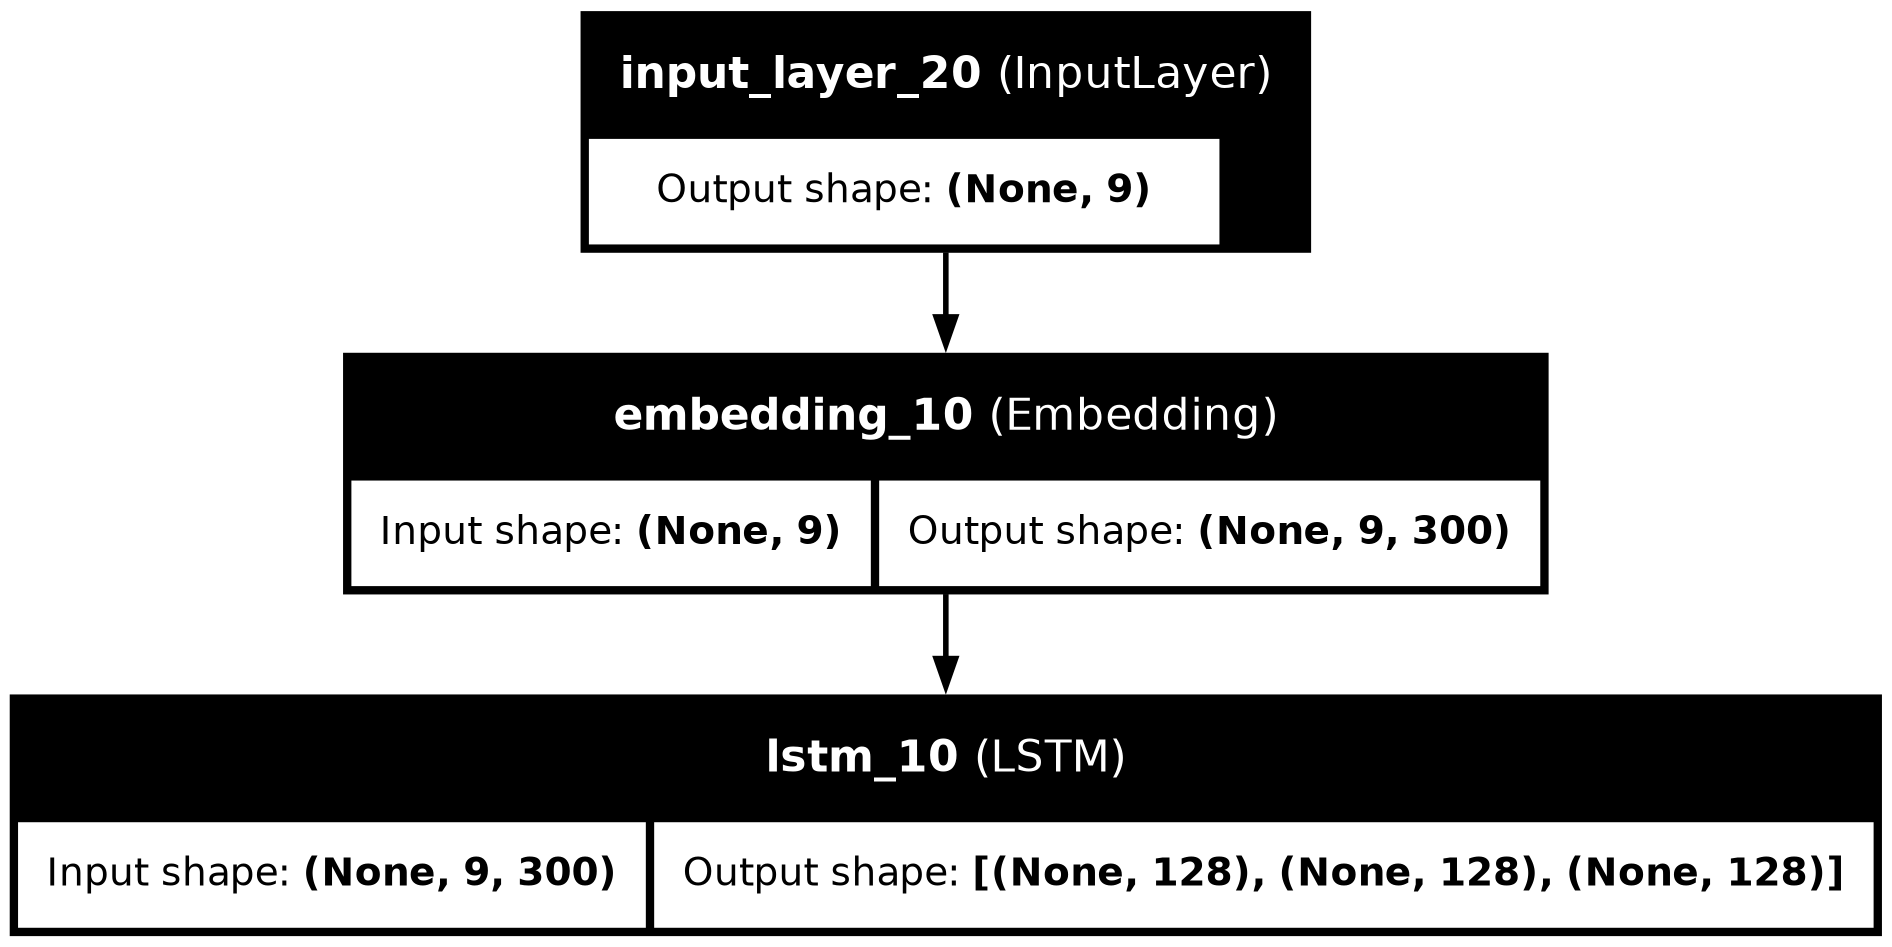

In [ ]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

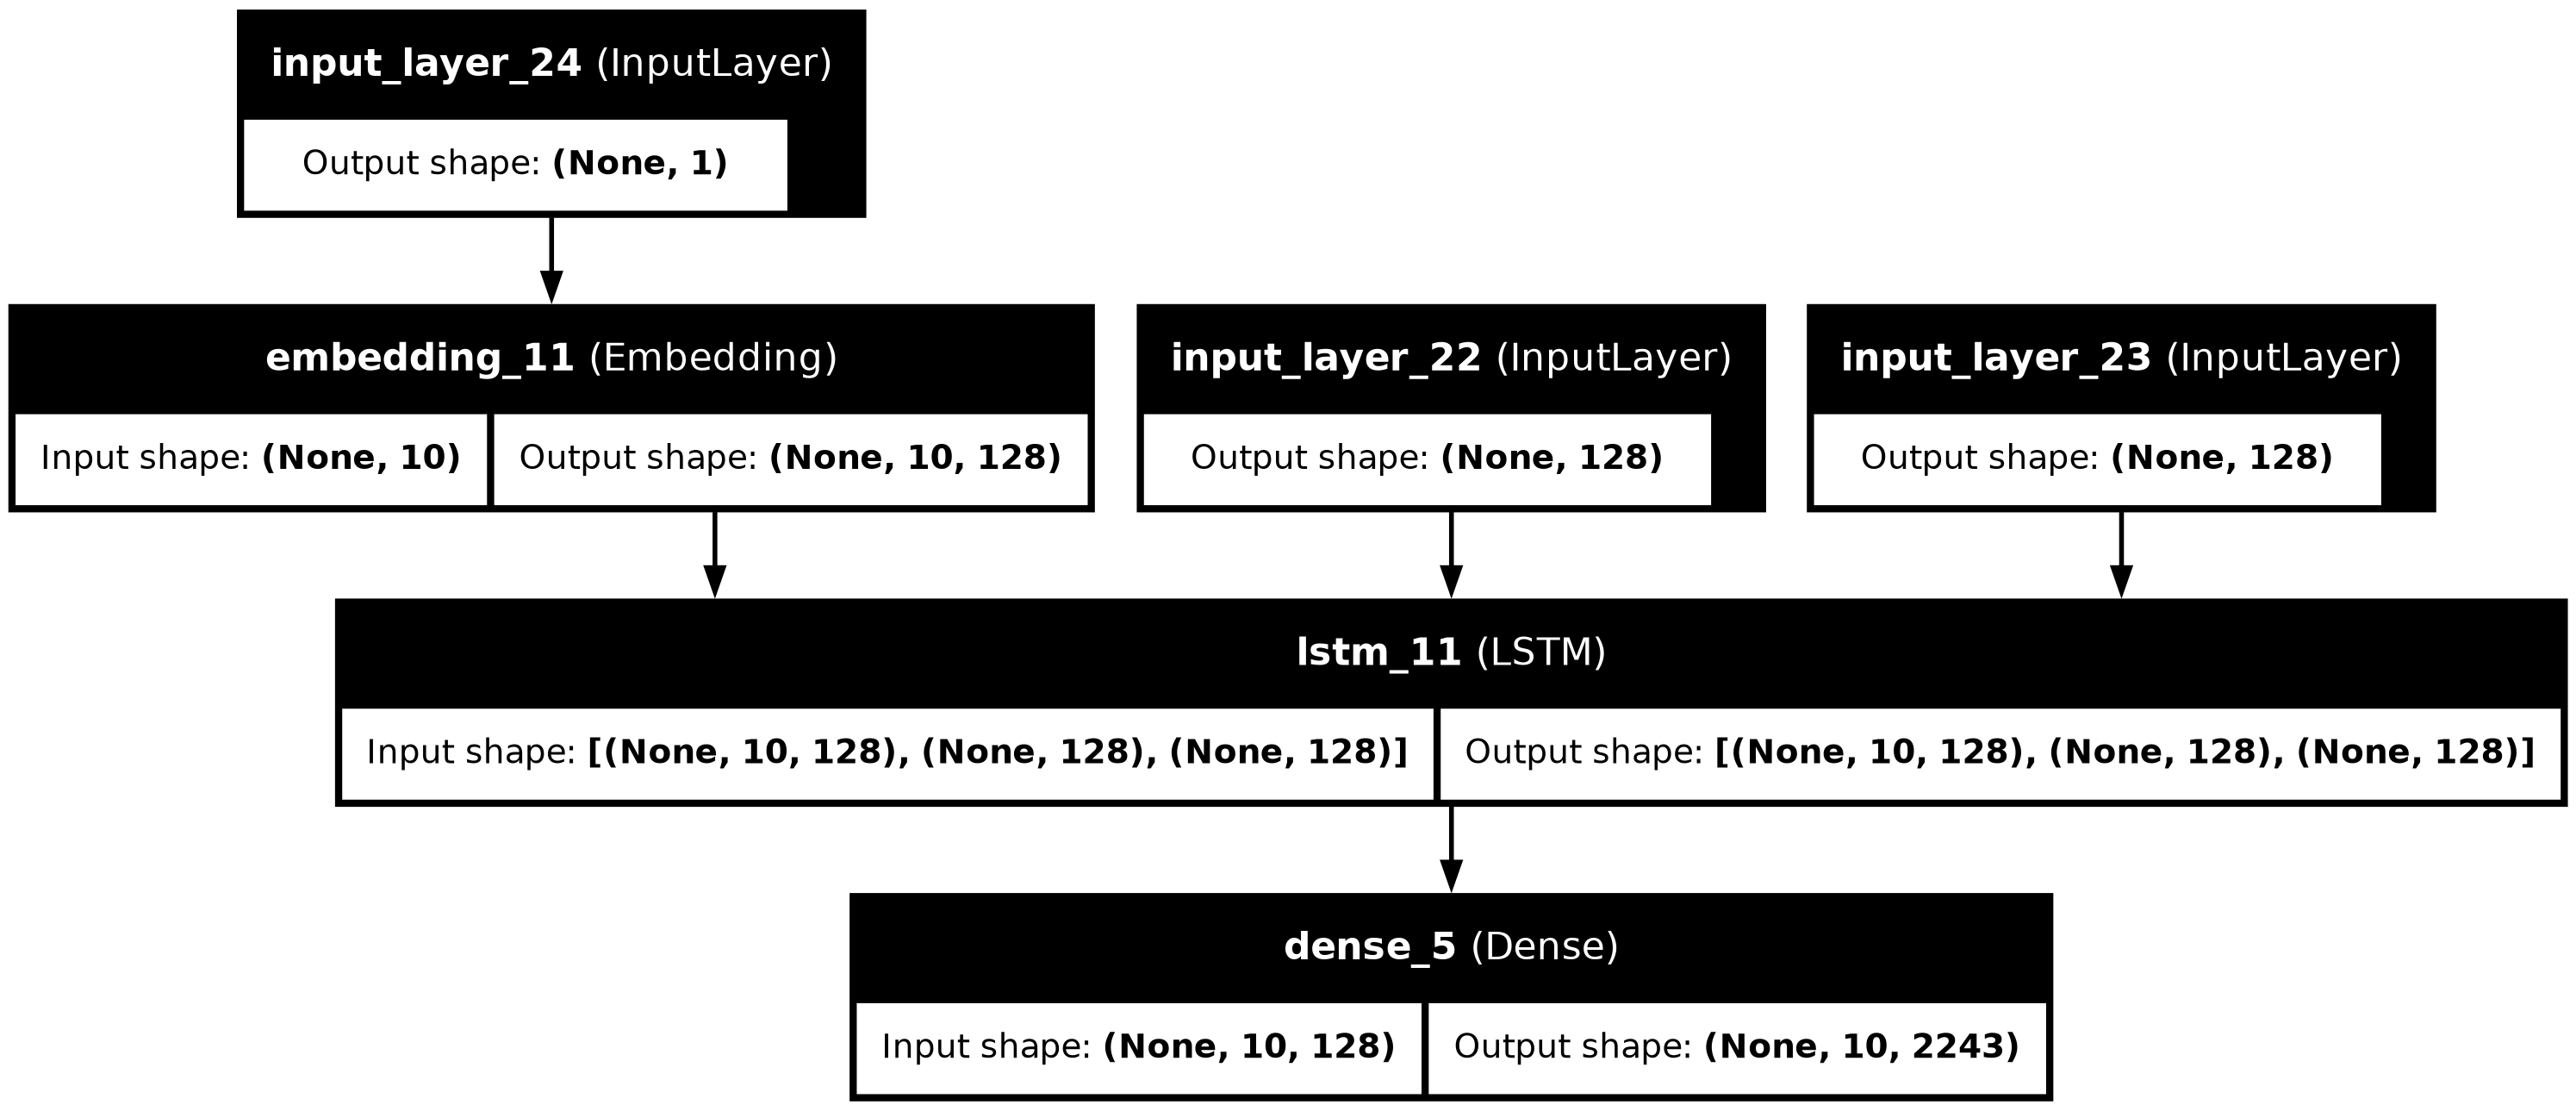

In [ ]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=30,
    validation_split=0.2)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5174 - loss: 4.3386 - val_accuracy: 0.5759 - val_loss: 2.3380
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6005 - loss: 2.1691 - val_accuracy: 0.6370 - val_loss: 2.1758
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6533 - loss: 1.9722 - val_accuracy: 0.6729 - val_loss: 2.0238
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6903 - loss: 1.7769 - val_accuracy: 0.6832 - val_loss: 1.9404
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7052 - loss: 1.6341 - val_accuracy: 0.6913 - val_loss: 1.8795
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7189 - loss: 1.5582 - val_accuracy: 0.7011 - val_loss: 1.8373
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7331 - loss: 1.4852 - val_accuracy: 0.7052 - val_loss: 1.8193
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7433 - loss: 1.4144 - val_accuracy:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

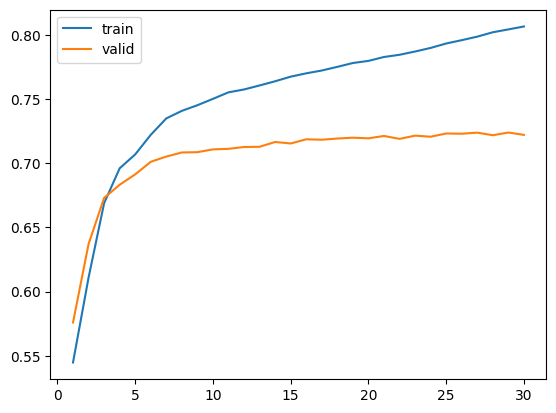

In [ ]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [ ]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def generate_answer(input_seq, encoder_model, decoder_model, max_out_len, word2idx_outputs, idx2word_target):
    """
    Genera la respuesta para el input usando los modelos de encoder-decoder.
    """
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        print("Predicted index:", idx)  # Print the predicted index to debug

        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        states_value = [h, c]
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)


In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
answer = generate_answer(
    input_seq=input_seq,
    encoder_model=encoder_model,
    decoder_model=decoder_model,
    max_out_len=max_out_len,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target
    )
print('-')
print('Input:', input_sentences[i])
print('Response:', answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted index: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted index: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted index: 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted index: 64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted index: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted index: 101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted index: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted index: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted index: 2
-
Input: what you do not
Response: i am not sure what you mean <sos> <sos> <sos>


In [ ]:
input_test = "How are you?"
#input_test_cleaned = clean_text(input_test)
print('Input:', input_test)
int_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", int_seq_test)
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_input_test)

# Generate the answer
answer = generate_answer(
    input_seq=encoder_input_test,
    encoder_model=encoder_model,
    decoder_model=decoder_model,
    max_out_len=max_out_len,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target
    )
print("Generated Answer:", answer)

Input: How are you?
Representacion en vector de tokens de ids [11, 8, 2]
Padding del vector: [[ 0  0  0  0  0  0 11  8  2]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted index: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted index: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted index: 41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted index: 49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted index: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted index: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted index: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted index: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted index: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted index: 2
Generated Answer: i am doing well how are you <sos> <sos> <sos>
